In [2]:
#pip install torch==2.0.1+cpu torchvision==0.15.2+cpu torchaudio==2.0.2+cpu --index-url https://download.pytorch.org/whl/cpu

# Environment Setup (Install Dependencies)

In [3]:
import torchaudio
print("Torchaudio imported successfully!")

Torchaudio imported successfully!


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
import shutil
shutil.rmtree("ImageBind", ignore_errors=True)

In [5]:
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind
!pip install -e .

C:\Users\User\ImageBind


Cloning into 'ImageBind'...


Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///C:/Users/User/ImageBind
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to c:\users\user\appdata\local\temp\pip-install-tl5pmqry\pytorchvideo_7428618d5bb54c249c077f1ecbeab2c7
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of imagebind to determine which version is compatible with other requirements. This could take a while.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git 'C:\Users\User\AppData\Local\Temp\pip-install-tl5pmqry\pytorchvideo_7428618d5bb54c249c077f1ecbeab2c7'
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
ERROR: Could not find a version that satisfies the requirement torch==1.13.1 (from imagebind) (from versions: 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1)
ERROR: No matching distribution found for torch==1.13.1


In [6]:
import os
print(os.getcwd())

C:\Users\User\ImageBind


In [9]:
#pip install timm

In [11]:
#pip install einops

In [12]:
from imagebind.models import imagebind_model
model = imagebind_model.imagebind_huge(pretrained=True)
print("Model loaded successfully!")

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  w

100%|█████████████████████████████████████████████████████████████████████████████| 4.47G/4.47G [07:17<00:00, 11.0MB/s]


Model loaded successfully!


# Library Import

In [13]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind.data import load_and_transform_vision_data

# Dataset Preparation: Custom PyTorch Dataset

In [14]:
class Flickr30kDataset(Dataset):
    def __init__(self, image_dir, caption_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = pd.read_csv(caption_file)
        self.data.dropna(inplace=True)  

        self.data = self.data.groupby('image').first().reset_index()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image'])
        caption = row['caption']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, caption, row['image']  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = Flickr30kDataset(r"C:\Users\User\flickr30k_images", r"C:\Users\User\captions.txt\captions.txt", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Extracting ImageBind Embeddings

In [15]:
device = "cpu"

In [16]:
model = imagebind_model.imagebind_huge(pretrained=True)
model = model.to(device)
model.eval()

print("Model is loaded on", device)

Model is loaded on cpu


In [17]:
imagebind_embeddings = []
labels = []

In [18]:
for images, captions, img_ids in dataloader:
    vision_data = images.to(device)

    with torch.no_grad():
        embeddings = model({ModalityType.VISION: vision_data})[ModalityType.VISION]

    imagebind_embeddings.append(embeddings.cpu().numpy())
    labels.extend(img_ids)

imagebind_embeddings = np.concatenate(imagebind_embeddings, axis=0)
labels = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def apply_pca(embeddings, labels, variance=0.95):
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42
    )
    pca = PCA(n_components=variance)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, y_train, y_test

X_ib_train, X_ib_test, y_ib_train, y_ib_test = apply_pca(imagebind_embeddings, labels)
X_clip_train, X_clip_test, y_clip_train, y_clip_test = apply_pca(clip_embeddings, clip_labels)

In [26]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-b34ttkvt
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369572 sha256=38f6969ac900872b3f7e15ae851965d570f99c29fa23551f863ca1cb2eb2f3c0
  Stored in directory: C:\Users\User\AppData\Local\Temp\pip-ephem-wheel-cache-3zfap12p\wheels\3f\7c\a4\9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-b34ttkvt'


# Extracting CLIP Embeddings

In [27]:
import clip
import torch
import numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

clip_embeddings = []
clip_labels = []

for images, captions, img_ids in dataloader:
    pil_images = [transforms.ToPILImage()(img) for img in images]
    clip_images = torch.stack([clip_preprocess(img) for img in pil_images]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(clip_images)

    clip_embeddings.append(image_features.cpu().numpy())
    clip_labels.extend(img_ids)

clip_embeddings = np.concatenate(clip_embeddings, axis=0)
clip_labels = np.array(clip_labels)

100%|███████████████████████████████████████| 338M/338M [00:35<00:00, 9.98MiB/s]


# PCA Dimensionality Reduction

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def apply_pca(embeddings, labels, variance=0.95):
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42
    )
    pca = PCA(n_components=variance)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, y_train, y_test

X_ib_train, X_ib_test, y_ib_train, y_ib_test = apply_pca(imagebind_embeddings, labels)
X_clip_train, X_clip_test, y_clip_train, y_clip_test = apply_pca(clip_embeddings, clip_labels)

# Classification with Gaussian Mixture Model (GMM)

In [33]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score 
from sklearn.decomposition import PCA

N_COMPONENTS = 20        

gmm_ib   = GaussianMixture(n_components=N_COMPONENTS, random_state=42).fit(X_ib_train)
gmm_clip = GaussianMixture(n_components=N_COMPONENTS, random_state=42).fit(X_clip_train)

ib_test_clusters   = gmm_ib.predict(X_ib_test)
clip_test_clusters = gmm_clip.predict(X_clip_test)

ib_sil   = silhouette_score(np.vstack([X_ib_train,  X_ib_test ]), 
                            np.hstack([gmm_ib.predict(X_ib_train),  ib_test_clusters ]))
clip_sil = silhouette_score(np.vstack([X_clip_train, X_clip_test]), 
                            np.hstack([gmm_clip.predict(X_clip_train), clip_test_clusters]))

print(f"ImageBind GMM silhouette: {ib_sil:.3f}")
print(f"CLIP      GMM silhouette: {clip_sil:.3f}")

ImageBind GMM silhouette: 0.033
CLIP      GMM silhouette: 0.042


In [34]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

K = 20                     
pseudo_labels_ib   = KMeans(n_clusters=K, random_state=0).fit_predict(imagebind_embeddings)
pseudo_labels_clip = KMeans(n_clusters=K, random_state=0).fit_predict(clip_embeddings)

def run_gmm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )
    gmm = GaussianMixture(n_components=len(np.unique(y_train)), random_state=0)
    gmm.fit(X_train, y_train)
    y_pred = gmm.predict(X_test)
    return accuracy_score(y_test, y_pred)

ib_acc   = run_gmm(imagebind_embeddings, pseudo_labels_ib)
clip_acc = run_gmm(clip_embeddings,    pseudo_labels_clip)

print(f"ImageBind + GMM accuracy (with K‑means labels): {ib_acc:.3f}")
print(f"CLIP      + GMM accuracy (with K‑means labels): {clip_acc:.3f}")

ImageBind + GMM accuracy (with K‑means labels): 0.124
CLIP      + GMM accuracy (with K‑means labels): 0.037


In [37]:
def run_gmm(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )
    gmm = GaussianMixture(n_components=len(np.unique(y_train)), random_state=0)
    gmm.fit(X_train, y_train)
    y_pred = gmm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc, y_pred, y_test

In [38]:
ib_acc, ib_preds, ib_true = run_gmm(imagebind_embeddings, pseudo_labels_ib)
clip_acc, clip_preds, clip_true = run_gmm(clip_embeddings, pseudo_labels_clip)

# Results Summary & Visualization

In [40]:
from sklearn.metrics import classification_report

print("Detailed Classification Report for ImageBind:")
print(classification_report(ib_true, ib_preds))

print("\nDetailed Classification Report for CLIP:")
print(classification_report(clip_true, clip_preds))

from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(name, y_true, y_pred):
    print(f"\n{name} Metrics:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")

print_metrics("ImageBind + GMM", ib_true, ib_preds)
print_metrics("CLIP + GMM", clip_true, clip_preds)

Detailed Classification Report for ImageBind:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       373
           1       0.00      0.00      0.00       427
           2       0.00      0.00      0.00       292
           3       0.00      0.00      0.00       420
           4       0.00      0.01      0.01       443
           5       0.01      0.02      0.01       197
           6       0.46      0.85      0.60       359
           7       0.00      0.00      0.00       307
           8       0.00      0.00      0.00       171
           9       0.00      0.00      0.00       238
          10       0.00      0.00      0.00       272
          11       0.47      0.42      0.45       528
          12       0.00      0.00      0.00       151
          13       0.49      0.60      0.54       360
          14       0.00      0.00      0.00       386
          15       0.00      0.00      0.00       271
          16       0.02      0.16  

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

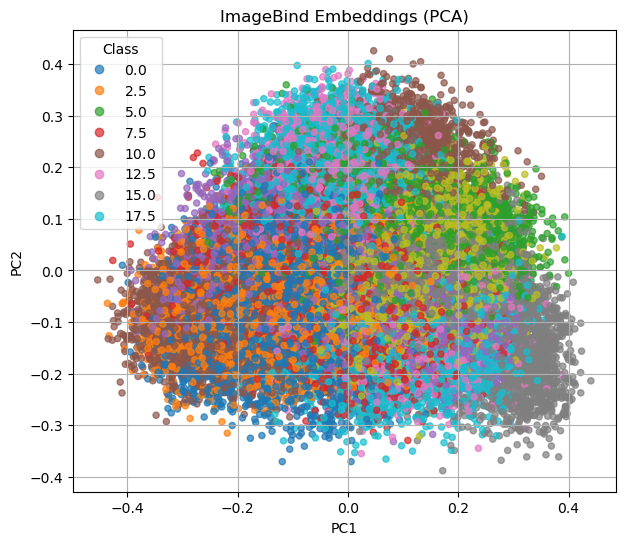

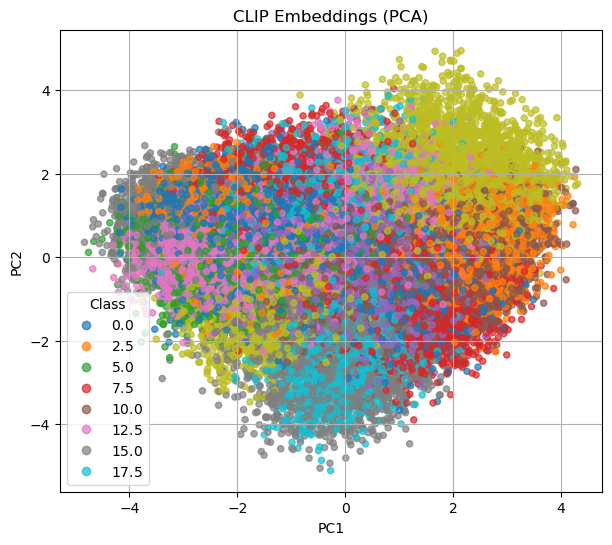

In [41]:
from sklearn.decomposition import PCA

def plot_2d_embeddings(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=20, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

plot_2d_embeddings(imagebind_embeddings, pseudo_labels_ib, "ImageBind Embeddings (PCA)")
plot_2d_embeddings(clip_embeddings, pseudo_labels_clip, "CLIP Embeddings (PCA)")


Classification Accuracy:
ImageBind + GMM: 0.1244
CLIP + GMM:      0.0373


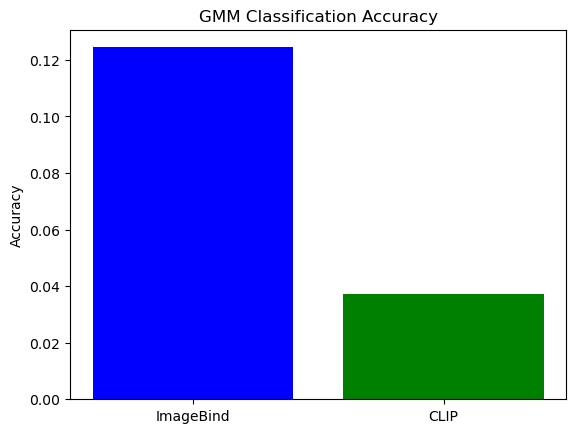

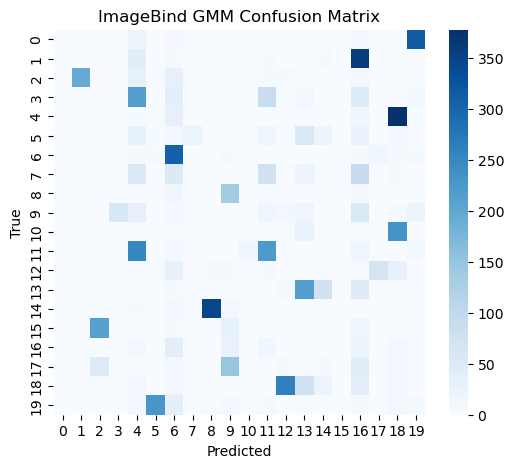

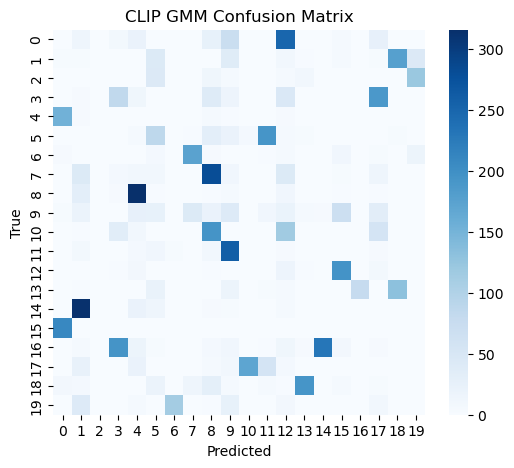

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\nClassification Accuracy:")
print(f"ImageBind + GMM: {ib_acc:.4f}")
print(f"CLIP + GMM:      {clip_acc:.4f}")

plt.bar(['ImageBind', 'CLIP'], [ib_acc, clip_acc], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("GMM Classification Accuracy")
plt.show()

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion(ib_true, ib_preds, "ImageBind GMM Confusion Matrix")
plot_confusion(clip_true, clip_preds, "CLIP GMM Confusion Matrix")